In [3]:
import sys
import os
from pathlib import Path
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from collections import ChainMap
from scipy.integrate import cumtrapz, trapz
import re
import importlib
import seaborn as sns
sns.set()

%matplotlib inline

In [4]:
# local modules
from fastsim import simdrivehot, simdrive, vehicle, cycle, params, utils
import hot_utilities as hot_utils
importlib.reload(hot_utils)
# importlib.reload(simdrive)
# importlib.reload(cycle)

<module 'hot_utilities' from 'C:\\Users\\cbaker2\\Documents\\GitHub\\fastsim\\docs\\hot_utilities.py'>

# IMPORTANT TASKS
## General
Make sure temp is initalized for each sim_drive_walk  
Make sure fc efficiency impact is accounted for  
Make sure heater affects engine temp and maybe aux load  
Make sure A/C affects aux load  
Cabin thermal model before tuning?

## Tuning
### Parameters
radiator convection coeff.  
idle convection coeff.  
heater something  
thermal mass = f(displacement)?  
diameter = f(displacement)?

### Objectives
fuel consumption  
temperature fit  
eng. temperature derivative fit  
cabin temperature fit  
cabin temperature derivative fit



In [28]:
t0 = time.time()
veh = vehicle.Vehicle('2012 Ford Fusion.csv')
veh_jit = veh.get_numba_veh()
print(f"Elapsed time to load vehicle: {time.time() - t0:.3g} s")

# correcting for actual vehicle coastdown parameters
veh_jit.dragCoef, veh_jit.wheelRrCoef = utils.abc_to_drag_coeffs(3625 / 2.2, 
                                                         veh.frontalAreaM2, 
                                                         35.55, 0.2159, 0.0182)
veh_jit.auxKw = 1.1 # getting difference between test and model to remain constant during idle
veh_jit.fcEffArray *= 1 / 1.0539 # correcting for remaining difference

Elapsed time to load vehicle: 0.0369 s


In [4]:
df = hot_utils.load_test_data(use_cs=True, use_hs=True)
idx = pd.IndexSlice # used to slice multi index 

Loading test data.
Elapsed time to read data files: 3.705e+00 s


## Baseline validation

In [5]:
t0 = time.time()
cyc_name = 'us06x2 95F hs'
test_time_steps = df.loc[idx[cyc_name, :, :], 'DAQ_Time[s]'].values

cycSecs = np.arange(0, round(test_time_steps[-1], 0))
cycMps = np.interp(cycSecs, 
    test_time_steps, 
    df.loc[idx[cyc_name, :, :], 'Dyno_Spd[mps]'].values)

cyc = cycle.Cycle(cyc_dict={'cycSecs':cycSecs, 'cycMps':cycMps})
cyc_jit = cyc.get_numba_cyc()
print("Elapsed time to create cycle: {:.2e} s".format(time.time() - t0))

Elapsed time to create cycle: 8.03e-01 s


In [6]:
t0 = time.time()
sd_baseline = simdrive.SimDriveJit(cyc_jit, veh_jit)
sd_baseline.sim_drive()
print(f"Elapsed time: {time.time() - t0:.3e} s")

Elapsed time: 4.616e+01 s


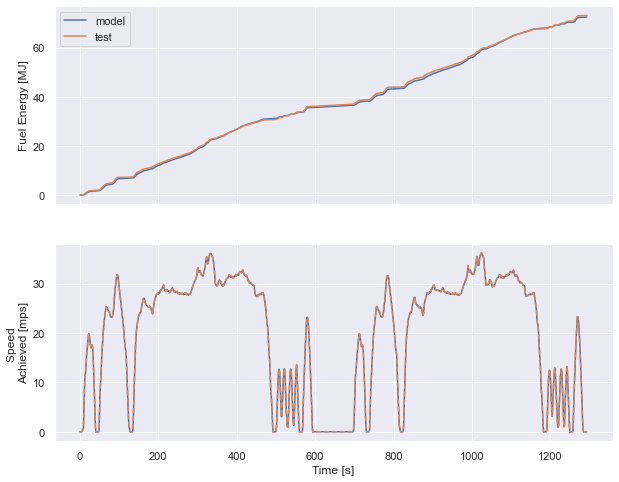

Model uses 0.92% less fuel than test.


In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,8))
ax1.plot(cyc.cycSecs[1:], cumtrapz(x=cyc.cycSecs, y=sd_baseline.fcKwInAch * 1e-3), label='model')
ax1.plot(test_time_steps[1:], cumtrapz(x=test_time_steps, y=df.loc[idx[cyc_name, :, :], 'Fuel_Power_Calc[kW]'] * 1e-3), label='test')
ax1.set_ylabel('Fuel Energy [MJ]')
ax1.legend()
ax2.plot(cyc.cycSecs, sd_baseline.mpsAch, label='model')
ax2.plot(df.loc[idx[cyc_name, :, :], 'Time[s]'], 
         df.loc[idx[cyc_name, :, :], 'Dyno_Spd[mps]'],
        label='test', linestyle='--')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Speed \nAchieved [mps]')
plt.show()

fuel_frac_err = (np.trapz(x=cyc.cycSecs, y=sd_baseline.fcKwInAch) - 
                np.trapz(x=test_time_steps, 
                         y=df.loc[idx[cyc_name, :, :], 'Fuel_Power_Calc[kW]'])) /\
                np.trapz(x=test_time_steps, 
                         y=df.loc[idx[cyc_name, :, :], 'Fuel_Power_Calc[kW]'])
less_more = 'less' if fuel_frac_err < 0 else 'more'
print(f"Model uses {abs(fuel_frac_err):.2%} " + less_more + " fuel than test.")

## Temperature effects

In [8]:
t0 = time.time()
cyc_name = 'us06x2 20F cs'
test_time_steps = df.loc[idx[cyc_name, :, :], 'DAQ_Time[s]'].values
test_te_amb = df.loc[idx[cyc_name, :, :], 'Cell_Temp[C]'].values

cycSecs = np.arange(0, round(test_time_steps[-1], 0))
cycMps = np.interp(cycSecs, 
    test_time_steps, 
    df.loc[idx[cyc_name, :, :], 'Dyno_Spd[mps]'].values)

cyc = cycle.Cycle(cyc_dict={'cycSecs':cycSecs, 'cycMps':cycMps})
cyc_jit = cyc.get_numba_cyc()
print("Elapsed time to create cycle: {:.2e} s".format(time.time() - t0))

Elapsed time to create cycle: 3.89e-02 s


In [9]:
t0 = time.time()
sim_drive = simdrivehot.SimDriveHotJit(cyc_jit, veh_jit, 
    teAmbDegC = np.interp(cycSecs, test_time_steps, test_te_amb),
      teFcInitDegC=df.loc[idx[cyc_name, :, 0], 'CylinderHeadTempC'][0]) 

params = ['fcThrmMass', 'fcDiam', 'hFcToAmbStop', 'radiator_eff',
          'fcTempEffOffset', 'fcTempEffSlope', 'teTStatDeltaDegC', 'teTStatSTODegC']
x = np.array([1.24638517e+02, 1.32330629e+00, 1.01128242e+02, 2.09979938e+01,
       2.90921564e-01, 7.94733767e-03, 6.63340063e+00, 8.83717822e+01]) 
# best as of 12 pm on 5 October 2020
for i, param in enumerate(params):
    sim_drive.__setattr__(param, x[i])
sim_drive.teTStatFODegC = sim_drive.teTStatSTODegC + sim_drive.teTStatDeltaDegC
    
sim_drive.sim_drive()
print(f'Elapsed time: {time.time() - t0:.2e} s')

Elapsed time: 5.26e+01 s


### Results

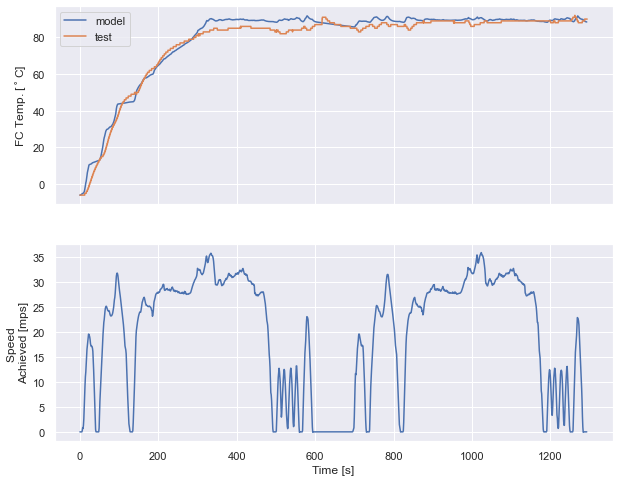

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,8))
ax1.plot(cyc.cycSecs, sim_drive.teFcDegC, label='model')
ax1.plot(test_time_steps, df.loc[idx[cyc_name, :, :], 'CylinderHeadTempC'], label='test')
ax1.set_ylabel('FC Temp. [$^\circ$C]')
ax1.legend()
ax2.plot(cyc.cycSecs, sim_drive.mpsAch)
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Speed \nAchieved [mps]')
plt.show()

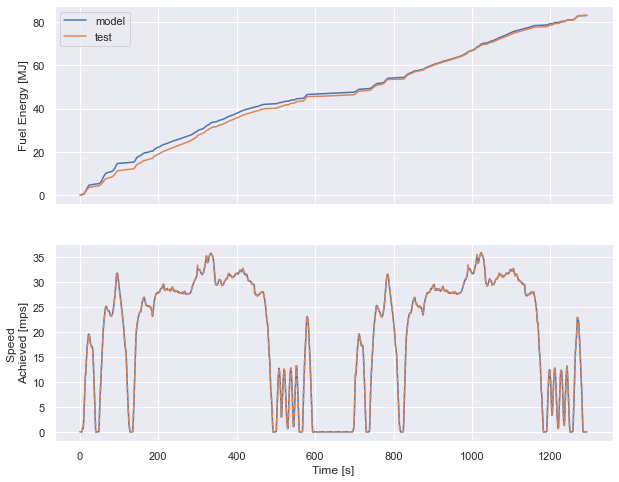

Model uses 0.02% more fuel than test.


In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,8))
ax1.plot(cyc.cycSecs[1:], cumtrapz(x=cyc.cycSecs, y=sim_drive.fcKwInAch * 1e-3), label='model')
ax1.plot(test_time_steps[1:], cumtrapz(x=test_time_steps, y=df.loc[idx[cyc_name, :, :], 'Fuel_Power_Calc[kW]'] * 1e-3), label='test')
ax1.set_ylabel('Fuel Energy [MJ]')
ax1.legend()
ax2.plot(cyc.cycSecs, sim_drive.mpsAch, label='model')
ax2.plot(df.loc[idx[cyc_name, :, :], 'Time[s]'], 
         df.loc[idx[cyc_name, :, :], 'Dyno_Spd[mps]'],
        label='test', linestyle='--')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Speed \nAchieved [mps]')
plt.show()

fuel_frac_err = (np.trapz(x=cyc.cycSecs, y=sim_drive.fcKwInAch) - 
                np.trapz(x=test_time_steps, 
                         y=df.loc[idx[cyc_name, :, :], 'Fuel_Power_Calc[kW]'])) /\
                np.trapz(x=test_time_steps, 
                         y=df.loc[idx[cyc_name, :, :], 'Fuel_Power_Calc[kW]'])
less_more = 'less' if fuel_frac_err < 0 else 'more'
print(f"Model uses {abs(fuel_frac_err):.2%} " + less_more + " fuel than test.")

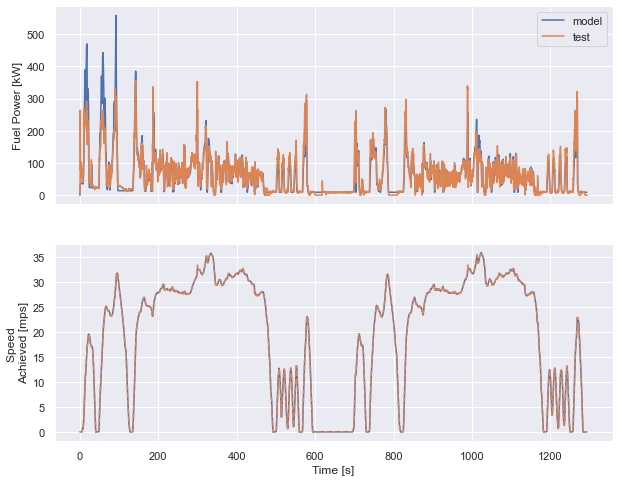

Model uses 0.02% more fuel than test.


In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,8))
ax1.plot(cyc.cycSecs, sim_drive.fcKwInAch, label='model')
ax1.plot(test_time_steps, df.loc[idx[cyc_name, :, :], 'Fuel_Power_Calc[kW]'], label='test')
ax1.set_ylabel('Fuel Power [kW]')
ax1.legend()
ax2.plot(cyc.cycSecs, sim_drive.mpsAch, label='model')
ax2.plot(df.loc[idx[cyc_name, :, :], 'Time[s]'], 
         df.loc[idx[cyc_name, :, :], 'Dyno_Spd[mps]'],
        label='test', linestyle='--')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Speed \nAchieved [mps]')
plt.show()

fuel_frac_err = (np.trapz(x=cyc.cycSecs, y=sim_drive.fcKwInAch) - 
                np.trapz(x=test_time_steps, 
                         y=df.loc[idx[cyc_name, :, :], 'Fuel_Power_Calc[kW]'])) /\
                np.trapz(x=test_time_steps, 
                         y=df.loc[idx[cyc_name, :, :], 'Fuel_Power_Calc[kW]'])
less_more = 'less' if fuel_frac_err < 0 else 'more'
print(f"Model uses {abs(fuel_frac_err):.2%} " + less_more + " fuel than test.")

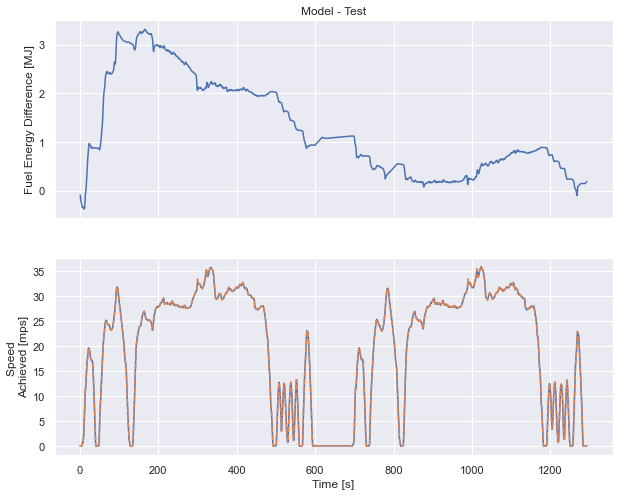

Model uses 0.02% more fuel than test.


In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,8))
ax1.plot(cyc.cycSecs[1:], 
         cumtrapz(x=cyc.cycSecs, 
                  y=sim_drive.fcKwInAch - 
                  np.interp(x=cyc.cycSecs, xp=test_time_steps, fp=df.loc[idx[cyc_name, :, :], 'Fuel_Power_Calc[kW]'])
                 ) * 1e-3)

ax1.set_ylabel('Fuel Energy Difference [MJ]')
ax2.plot(cyc.cycSecs, sim_drive.mpsAch, label='model')
ax2.plot(df.loc[idx[cyc_name, :, :], 'Time[s]'], 
         df.loc[idx[cyc_name, :, :], 'Dyno_Spd[mps]'],
        label='test', linestyle='--')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Speed \nAchieved [mps]')
ax1.set_title('Model - Test')
plt.show()

fuel_frac_err = (np.trapz(x=cyc.cycSecs, y=sim_drive.fcKwInAch) - 
                np.trapz(x=test_time_steps, 
                         y=df.loc[idx[cyc_name, :, :], 'Fuel_Power_Calc[kW]'])) /\
                np.trapz(x=test_time_steps, 
                         y=df.loc[idx[cyc_name, :, :], 'Fuel_Power_Calc[kW]'])
less_more = 'less' if fuel_frac_err < 0 else 'more'
print(f"Model uses {abs(fuel_frac_err):.2%} " + less_more + " fuel than test.")

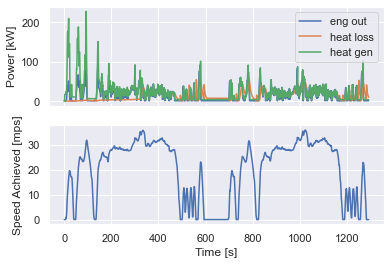

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(cyc.cycSecs, sim_drive.fcKwOutAch, label='eng out')
ax1.plot(cyc.cycSecs, sim_drive.fcConvToAmbKw, label='heat loss')
ax1.plot(cyc.cycSecs, sim_drive.fcHeatGenKw, label='heat gen')
ax1.set_ylabel('Power [kW]')
ax1.legend()
ax2.plot(cyc.cycSecs, sim_drive.mpsAch)
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Speed Achieved [mps]')
plt.show()

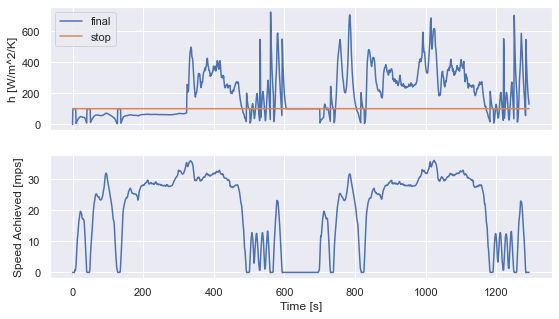

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(9,5))
ax1.plot(cyc.cycSecs, sim_drive.hFcToAmb, label='final')
ax1.plot(cyc.cycSecs, sim_drive.hFcToAmbStop * np.ones(len(cyc.cycSecs)), 
         label='stop')
ax1.set_ylabel('h [W/m^2/K]')
ax1.legend()
ax2.plot(cyc.cycSecs, sim_drive.mpsAch)
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Speed Achieved [mps]')
plt.show()

## Showing the FE impact for a sweep of ambient and starting temperatures

In [16]:
t0 = time.time()

init_temps_degC = np.linspace(-20, 90, 100)
amb_temps_degC = np.arange(-20, 60, 20)
mpg = np.zeros([len(init_temps_degC), len(amb_temps_degC)])

for i, init_temp in enumerate(init_temps_degC):
    for j, amb_temp in enumerate(amb_temps_degC):
        sim_drive.init_thermal_arrays(np.ones(len(cyc.cycSecs)) * amb_temp)
        sim_drive.teFcInitDegC = init_temp
        sim_drive.teCabInitDegC = init_temp

#         sim_drive = simdrivehot.SimDriveHotJit(cyc_jit, veh_jit, 
#             teAmbDegC = np.ones(len(cyc.cycSecs)) * amb_temp,
#           teFcInitDegC = init_temp) 

#         params = ['fcThrmMass', 'fcDiam', 'hFcToAmbStop', 'radiator_eff',
#                   'fcTempEffOffset', 'fcTempEffSlope', 'teTStatDeltaDegC', 'teTStatSTODegC']
#         x = np.array([1.24638517e+02, 1.32330629e+00, 1.01128242e+02, 2.09979938e+01,
#                2.90921564e-01, 7.94733767e-03, 6.63340063e+00, 8.83717822e+01]) 
#         # best as of 12 pm on 5 October 2020
        
#         for k, param in enumerate(params):
#             sim_drive.__setattr__(param, x[k])
#         sim_drive.teTStatFODegC = sim_drive.teTStatSTODegC + sim_drive.teTStatDeltaDegC
        
        sim_drive.sim_drive()

        mpg[i, j] = sim_drive.mpgge

print(f'Elapsed time: {time.time() - t0:.2e} s')

Elapsed time: 2.66e+00 s


In [17]:
sim_drive_no_thrm = simdrive.SimDriveJit(cyc_jit, veh_jit)
sim_drive_no_thrm.sim_drive()

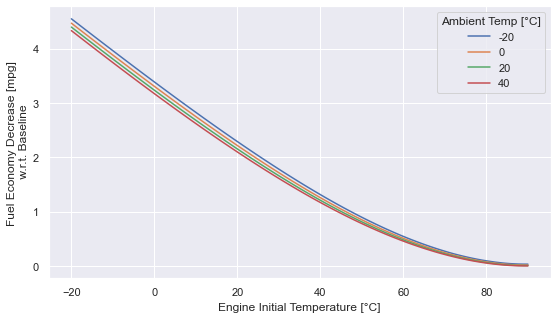

In [18]:
plt.figure(figsize=(9,5))
for i, amb_temp in enumerate(amb_temps_degC):
    plt.plot(init_temps_degC, sim_drive_no_thrm.mpgge - mpg[:, i], label=amb_temp)
plt.legend(title='Ambient Temp [°C]')
plt.xlabel('Engine Initial Temperature [°C]')
plt.ylabel('Fuel Economy Decrease [mpg]' + '\n w.r.t. Baseline')
# plt.plot(init_temps_degC, np.ones(len(init_temps_degC)) * sim_drive_no_thrm.mpgge)
plt.savefig('plots/FE vs temp sweep.svg')
plt.show()

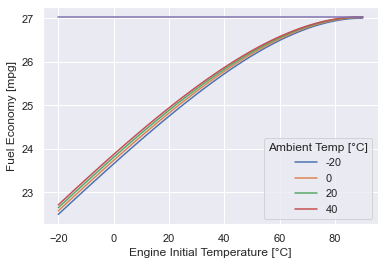

In [19]:
plt.figure()
for i, amb_temp in enumerate(amb_temps_degC):
    plt.plot(init_temps_degC, mpg[:, i], label=amb_temp)
plt.legend(title='Ambient Temp [°C]')
plt.xlabel('Engine Initial Temperature [°C]')
plt.ylabel('Fuel Economy [mpg]')
plt.plot(init_temps_degC, np.ones(len(init_temps_degC)) * sim_drive_no_thrm.mpgge)
plt.savefig('plots/FE vs temp sweep.svg')
plt.show()

Text(0, 0.5, 'Engine Initial Temperature [°C]')

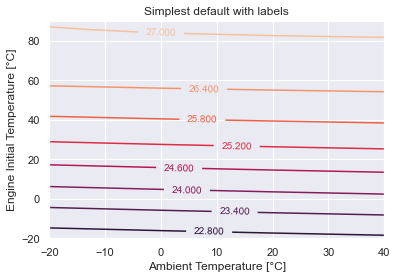

In [20]:
X, Y = np.meshgrid(amb_temps_degC, init_temps_degC)
fig, ax = plt.subplots()
CS = ax.contour(X, Y, mpg)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Simplest default with labels')
ax.set_xlabel('Ambient Temperature [°C]')
ax.set_ylabel('Engine Initial Temperature [°C]')

## Testing out various ways of accessing arrays and running fastsim

### CPU Time impact of running fastsim at smaller time steps

In [21]:
# instantiate a vehicle
t0 = time.time()
veh_jit = vehicle.Vehicle(1).get_numba_veh()
print("Elapsed time: {:.3e}".format(time.time() - t0))

Elapsed time: 1.200e+00


In [22]:
t0 = time.time()

# check elapsed time for standard udds
cyc_jit = cycle.Cycle('udds').get_numba_cyc()
sim_drive = simdrivehot.SimDriveHotJit(cyc_jit, veh_jit, 
    teAmbDegC = 22 * np.ones(len(cyc_jit.cycSecs)),
      teFcInitDegC=22) 
sim_drive.sim_drive()

t_standard = time.time() - t0
print("Elapsed time for standard UDDS: {:.3e}".format(t_standard))

Elapsed time for standard UDDS: 1.760e+00


In [23]:
t0_10Hz = time.time()

cyc10Hz_jit = cycle.Cycle(
    cyc_dict = cycle.resample(
        cycle.Cycle('udds').get_cyc_dict(),
        new_dt=0.1)).get_numba_cyc()
sim_drive10Hz = simdrivehot.SimDriveHotJit(cyc10Hz_jit, veh_jit, 
    teAmbDegC = 22 * np.ones(len(cyc10Hz_jit.cycSecs)),
      teFcInitDegC=22) 
sim_drive10Hz.sim_drive()

t_10Hz = time.time() - t0_10Hz

print("Elapsed time for 10 Hz UDDS: {:.3e}".format(t_10Hz))

Elapsed time for 10 Hz UDDS: 2.264e-01


10 Hz is more than 10x slower than 1 Hz so avoid it

### Comparing various df slicing schemes

In [24]:
# integrating the whole thing
t0 = time.time()
mean = np.trapz(x=df.loc[idx[cyc_name, :, :], 'DAQ_Time[s]'].values,
                y=df.loc[idx[cyc_name, :, :], 'Dyno_Spd[mps]'].values) \
    / df.loc[idx[cyc_name, :, :], 'DAQ_Time[s]'].values[-1]
print("Elapsed time: {:.3e} s".format(time.time() - t0))
print(f'mean = {mean:.6e}')

Elapsed time: 4.787e-02 s
mean = 1.990116e+01


In [25]:
# integrating every 10th step
t0 = time.time()
mean = np.trapz(x=df.loc[idx[cyc_name, :, :], 'DAQ_Time[s]'].values[::10],
                y=df.loc[idx[cyc_name, :, :], 'Dyno_Spd[mps]'].values[::10]) \
    / df.loc[idx[cyc_name, :, :], 'DAQ_Time[s]'].values[-1]
print("Elapsed time: {:.3e} s".format(time.time() - t0))
print(f'mean = {mean:.6e}')

Elapsed time: 4.089e-02 s
mean = 1.990126e+01


In [26]:
# assigning to separate variable beforehand
x=df.loc[idx[cyc_name, :, :], 'DAQ_Time[s]'].values[::10]
y=df.loc[idx[cyc_name, :, :], 'Dyno_Spd[mps]'].values[::10]
t0 = time.time()
mean = np.trapz(x=x,
                y=y) \
    / df.loc[idx[cyc_name, :, :], 'DAQ_Time[s]'].values[-1]
print("Elapsed time: {:.3e} s".format(time.time() - t0))
print(f'mean = {mean:.6e}')

Elapsed time: 1.293e-02 s
mean = 1.990126e+01


In [27]:
# interpolating every 10th step
t0 = time.time()
mean = np.trapz(x=df.loc[idx[cyc_name, :, :], 'DAQ_Time[s]'].values[::10],
                y=np.interp(x=df.loc[idx[cyc_name, :, :], 'DAQ_Time[s]'].values[::10],
                xp=df.loc[idx[cyc_name, :, :], 'DAQ_Time[s]'].values,
                   fp=df.loc[idx[cyc_name, :, :], 'Dyno_Spd[mps]'].values)) \
    / df.loc[idx[cyc_name, :, :], 'DAQ_Time[s]'].values[-1]
print("Elapsed time: {:.3e} s".format(time.time() - t0))
print(f'mean = {mean:.6e}')

Elapsed time: 6.483e-02 s
mean = 1.990126e+01
